## Import the necessary libraries

job ID ascending = time series??? coba di urutkan by job ID dan pake KougamiNet

In [1]:
# Arrays and datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Machine learning models
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Feature engineering and model evaluation
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif

from imblearn.over_sampling import RandomOverSampler

In [2]:
# Use Intel's optimized sklearn
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Functions to simplify some processes

In [4]:
# get the model algorithm using it's default parameters
def get_model(name):
    if name == "knn":
        return KNeighborsClassifier()
    elif name == "svm":
        return SVC(gamma="auto", random_state=42)
    elif name == "logistic":
        return LogisticRegression(random_state=42)
    elif name == "tree":
        return DecisionTreeClassifier(random_state=42)
    elif name == "forest":
        return RandomForestClassifier(random_state=42)
    elif name == "mlp":
        return MLPClassifier(random_state=42)

In [5]:
# helper function to run predictions
def run_predictions(data, model_name, oversample=False, scale=False, pca=False, cv=10, test_size=0.33):
    print("Running preprocessing...")

    # for reproducible results
    np.random.seed(42)

    # split features and label
    X = data.iloc[:, 1:-1].values
    y = data.iloc[:, -1].values

    # do oversampling to handle imbalanced class
    sampler = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = sampler.fit_resample(X, y) if oversample else (X, y)

    # split train and test (33% test, 67% train)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, stratify=y_resampled, test_size=test_size, random_state=42)

    # create classification pipeline
    pipeline_elements = []
    if scale:
        pipeline_elements.append(('scaler', RobustScaler()))
    if pca:
        pipeline_elements.append(('reduce_dimension', PCA(n_components=3)))

    pipeline_elements.append(('classifier', get_model(model_name)))
    
    # make pipeline
    clf = Pipeline(pipeline_elements)
    print("Pipeline: " + " -> ".join(clf.named_steps.keys()))

    # cross validation
    print("\n--- Cross Validation ---")
    scores = cross_validate(clf, X_resampled, y_resampled, cv=cv)
    print(pd.DataFrame.from_dict(scores))
    print("Average score: ", np.mean(scores["test_score"]))

    # fit the model and evaluate    
    print("\n--- Train/Test Split ---")
    clf.fit(X_train, y_train) # force retrain the model
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))

    # plot the confusion matrix from train/test split
    plot_confusion_matrix(clf, X_test, y_test)

## Load the dataset

In [6]:
# load dataset
df = pd.read_csv('dataset/train_data.csv')

In [7]:
# sample top 5 data
df.head()

,job_id,memory_GB,network_log10_MBps,local_IO_log10_MBps,NFS_IO_log10_MBps,failed
0,jobID1634295,44.3904,-1.0262,0.8033,-3.0000,0
1,jobID2033452,31.5839,-1.4608,-0.6080,-2.9967,0
2,jobID2068800,154.4610,-0.5508,-0.3637,-3.0000,0
3,jobID78826,71.8570,3.5701,-0.1281,2.3040,0
4,jobID2935014,30.0370,3.3094,-0.9463,-3.0000,0


In [8]:
# split to features and label
X = df.iloc[:, 1:-1].values
y = df.iloc[:, -1].values

## Baseline Models

Running preprocessing...
Pipeline: classifier

--- Cross Validation ---
   fit_time  score_time  test_score
0  0.190000    0.054000      0.9460
1  0.020000    0.051500      0.9385
2  0.020501    0.052499      0.9415
3  0.021500    0.051999      0.9385
4  0.021999    0.051500      0.9430
5  0.021001    0.051499      0.9455
6  0.020499    0.052003      0.9425
7  0.020499    0.052000      0.9400
8  0.020500    0.052000      0.9450
9  0.019999    0.051998      0.9395
Average score:  0.942

--- Train/Test Split ---
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      6063
           1       0.78      0.44      0.56       537

    accuracy                           0.94      6600
   macro avg       0.87      0.71      0.77      6600
weighted avg       0.94      0.94      0.94      6600



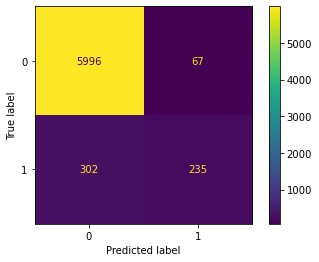

In [9]:
# K-Nearest Neighbor
run_predictions(df, "knn")

Running preprocessing...
Pipeline: classifier

--- Cross Validation ---
   fit_time  score_time  test_score
0  0.007499    0.000501      0.9190
1  0.010506    0.000995      0.9190
2  0.006499    0.000501      0.9190
3  0.007001    0.000500      0.9190
4  0.006500    0.000000      0.9185
5  0.006500    0.000500      0.9185
6  0.005999    0.000501      0.9185
7  0.006500    0.000000      0.9185
8  0.006000    0.000501      0.9185
9  0.005999    0.000000      0.9185
Average score:  0.9187

--- Train/Test Split ---
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      6063
           1       0.00      0.00      0.00       537

    accuracy                           0.92      6600
   macro avg       0.46      0.50      0.48      6600
weighted avg       0.84      0.92      0.88      6600

E:\app-store\bin\miniconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined

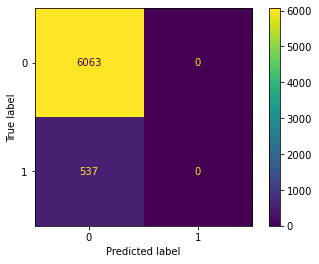

In [10]:
# Logistic Regression
run_predictions(df, "logistic")

Running preprocessing...
Pipeline: classifier

--- Cross Validation ---
   fit_time  score_time  test_score
0  0.072500    0.001001      0.9190
1  0.070001    0.000999      0.9035
2  0.069001    0.001000      0.9110
3  0.067500    0.001002      0.9150
4  0.070498    0.000503      0.9140
5  0.068998    0.000502      0.9125
6  0.066498    0.001001      0.9145
7  0.068998    0.001001      0.9095
8  0.071999    0.001001      0.9080
9  0.068999    0.001002      0.9185
Average score:  0.9125500000000001

--- Train/Test Split ---
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      6063
           1       0.49      0.48      0.48       537

    accuracy                           0.92      6600
   macro avg       0.72      0.72      0.72      6600
weighted avg       0.92      0.92      0.92      6600



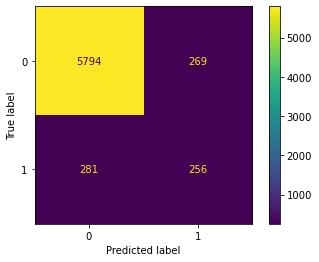

In [11]:
# Decision Tree
run_predictions(df, "tree")

Running preprocessing...
Pipeline: classifier

--- Cross Validation ---
   fit_time  score_time  test_score
0  2.236999    0.033501      0.9495
1  2.241001    0.032498      0.9405
2  2.227500    0.033500      0.9475
3  2.246500    0.033000      0.9435
4  2.246999    0.033001      0.9450
5  2.209502    0.032998      0.9445
6  2.228498    0.033001      0.9445
7  2.203499    0.033001      0.9420
8  2.273500    0.035001      0.9430
9  2.211999    0.033001      0.9460
Average score:  0.9446

--- Train/Test Split ---
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      6063
           1       0.87      0.39      0.54       537

    accuracy                           0.95      6600
   macro avg       0.91      0.69      0.75      6600
weighted avg       0.94      0.95      0.94      6600



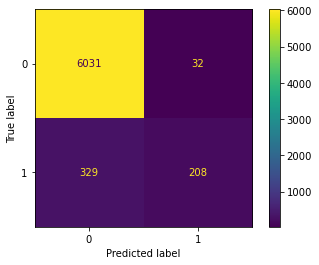

In [12]:
# Random Forest
run_predictions(df, "forest")

Running preprocessing...
Pipeline: classifier

--- Cross Validation ---
E:\app-store\bin\miniconda3\envs\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
E:\app-store\bin\miniconda3\envs\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
E:\app-store\bin\miniconda3\envs\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
    fit_time  score_time  test_score
0   6.372499    0.001500      0.9395
1   6.421501    0.001999      0.9335
2   4.833003    0.002000      0.9385
3   8.470997    0.003003      0.9365
4  10.933500  

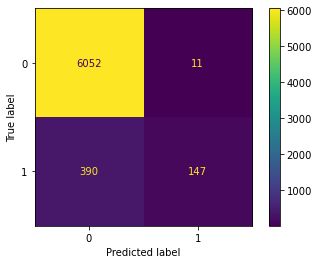

In [13]:
# Multilayer Perceptron
run_predictions(df, "mlp")

Running preprocessing...
Pipeline: classifier

--- Cross Validation ---
   fit_time  score_time  test_score
0  5.229378    0.626500      0.9430
1  4.720030    0.610470      0.9390
2  4.797000    0.622500      0.9400
3  4.798999    0.617500      0.9390
4  4.651500    0.619500      0.9420
5  4.776001    0.618502      0.9365
6  4.826999    0.643497      0.9420
7  4.962998    0.627501      0.9375
8  4.901000    0.630501      0.9360
9  4.846000    0.623001      0.9405
Average score:  0.93955

--- Train/Test Split ---
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      6063
           1       0.87      0.33      0.47       537

    accuracy                           0.94      6600
   macro avg       0.91      0.66      0.72      6600
weighted avg       0.94      0.94      0.93      6600



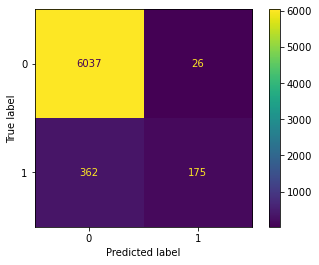

In [14]:
# Support Vector Machine
run_predictions(df, "svm")

## Using Oversampling

Running preprocessing...
Pipeline: classifier

--- Cross Validation ---
   fit_time  score_time  test_score
0  0.059498    0.096001    0.938503
1  0.058998    0.095528    0.944490
2  0.059969    0.093000    0.933605
3  0.057999    0.094000    0.940952
4  0.059500    0.092000    0.941224
5  0.055500    0.091502    0.937687
6  0.055000    0.091500    0.944218
7  0.054500    0.091500    0.943401
8  0.055000    0.095003    0.944475
9  0.057498    0.095499    0.943658
Average score:  0.9412214457911636

--- Train/Test Split ---
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      6064
           1       0.88      0.99      0.93      6063

    accuracy                           0.93     12127
   macro avg       0.94      0.93      0.93     12127
weighted avg       0.94      0.93      0.93     12127



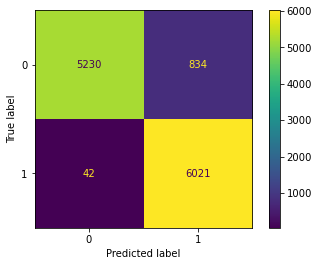

In [15]:
run_predictions(df, "knn", oversample=True)

Running preprocessing...
Pipeline: classifier

--- Cross Validation ---
   fit_time  score_time  test_score
0  0.016000    0.001004    0.644354
1  0.010502    0.000499    0.660136
2  0.012000    0.000499    0.663129
3  0.012501    0.000500    0.645986
4  0.010000    0.001502    0.647347
5  0.007498    0.000500    0.649524
6  0.010998    0.000502    0.646259
7  0.010500    0.000499    0.649252
8  0.008502    0.000498    0.661677
9  0.010999    0.000528    0.672020
Average score:  0.6539682638433708

--- Train/Test Split ---
              precision    recall  f1-score   support

           0       0.66      0.61      0.63      6064
           1       0.64      0.68      0.66      6063

    accuracy                           0.65     12127
   macro avg       0.65      0.65      0.65     12127
weighted avg       0.65      0.65      0.65     12127



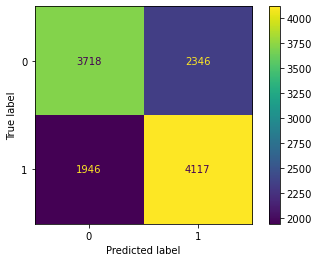

In [16]:
run_predictions(df, "logistic", oversample=True)

Running preprocessing...
Pipeline: classifier

--- Cross Validation ---
   fit_time  score_time  test_score
0  0.088499    0.001001    0.979320
1  0.084499    0.001001    0.977959
2  0.086000    0.001000    0.973333
3  0.087000    0.000999    0.977687
4  0.085502    0.001502    0.973333
5  0.085996    0.001001    0.980136
6  0.087501    0.001001    0.974694
7  0.084998    0.001001    0.976327
8  0.086500    0.001000    0.980131
9  0.085500    0.001000    0.978225
Average score:  0.9771145130888502

--- Train/Test Split ---
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      6064
           1       0.94      1.00      0.97      6063

    accuracy                           0.97     12127
   macro avg       0.97      0.97      0.97     12127
weighted avg       0.97      0.97      0.97     12127



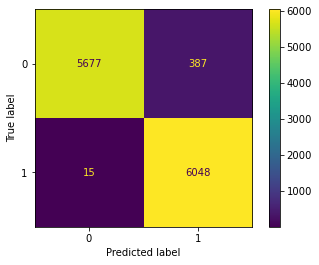

In [17]:
run_predictions(df, "tree", oversample=True)

Running preprocessing...
Pipeline: classifier

--- Cross Validation ---
   fit_time  score_time  test_score
0  3.191001    0.055500    0.989116
1  3.282001    0.056499    0.990204
2  3.222999    0.055000    0.986939
3  3.231500    0.056501    0.991020
4  3.288502    0.054997    0.992925
5  3.231500    0.054501    0.990204
6  3.219000    0.055000    0.988844
7  3.222999    0.055000    0.987755
8  3.209500    0.054999    0.991018
9  3.183501    0.054500    0.991835
Average score:  0.9899859279585541

--- Train/Test Split ---
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      6064
           1       0.97      1.00      0.98      6063

    accuracy                           0.98     12127
   macro avg       0.98      0.98      0.98     12127
weighted avg       0.98      0.98      0.98     12127



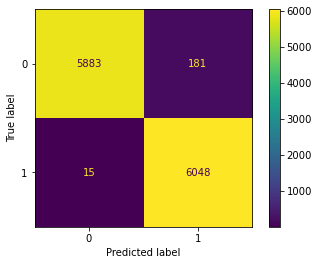

In [18]:
run_predictions(df, "forest", oversample=True)

Running preprocessing...
Pipeline: classifier

--- Cross Validation ---
E:\app-store\bin\miniconda3\envs\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
E:\app-store\bin\miniconda3\envs\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
E:\app-store\bin\miniconda3\envs\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
E:\app-store\bin\miniconda3\envs\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

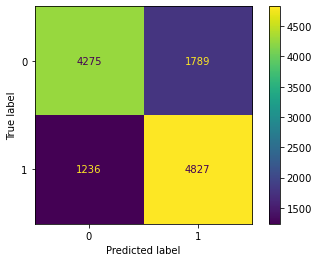

In [19]:
run_predictions(df, "mlp", oversample=True)

Running preprocessing...
Pipeline: classifier

--- Cross Validation ---
    fit_time  score_time  test_score
0  31.060997    4.504497    0.847075
1  28.791500    4.470505    0.842177
2  31.232500    4.499495    0.837551
3  31.261002    4.502501    0.848707
4  28.768999    4.527498    0.841361
5  31.424001    4.501998    0.848163
6  28.566500    4.466500    0.840272
7  31.187999    4.506500    0.847619
8  27.560000    4.508500    0.850844
9  28.803504    4.532499    0.848666
Average score:  0.8452435240835584

--- Train/Test Split ---
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      6064
           1       0.83      0.87      0.85      6063

    accuracy                           0.84     12127
   macro avg       0.84      0.84      0.84     12127
weighted avg       0.84      0.84      0.84     12127



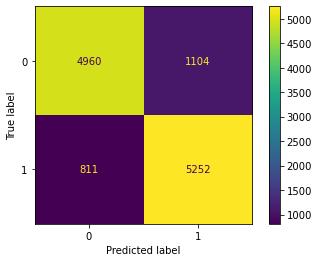

In [20]:
run_predictions(df, "svm", oversample=True)

## Using Feature Scaling

Running preprocessing...
Pipeline: scaler -> classifier

--- Cross Validation ---
   fit_time  score_time  test_score
0  0.674953    0.054527      0.9465
1  0.023474    0.054000      0.9360
2  0.024502    0.052498      0.9425
3  0.024745    0.052754      0.9395
4  0.023000    0.055501      0.9400
5  0.025497    0.054499      0.9430
6  0.024026    0.053973      0.9385
7  0.025053    0.054447      0.9465
8  0.023999    0.054002      0.9395
9  0.023998    0.054000      0.9425
Average score:  0.94145

--- Train/Test Split ---
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      6063
           1       0.74      0.42      0.54       537

    accuracy                           0.94      6600
   macro avg       0.84      0.70      0.75      6600
weighted avg       0.93      0.94      0.93      6600



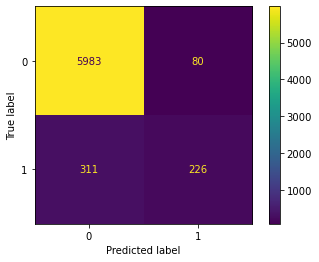

In [21]:
run_predictions(df, "knn", scale=True)

Running preprocessing...
Pipeline: scaler -> classifier

--- Cross Validation ---
   fit_time  score_time  test_score
0  0.012000    0.001501      0.9190
1  0.009003    0.001534      0.9190
2  0.006972    0.001000      0.9190
3  0.007000    0.001004      0.9190
4  0.007995    0.000501      0.9185
5  0.006999    0.001000      0.9185
6  0.006000    0.000500      0.9185
7  0.007000    0.000500      0.9185
8  0.006501    0.000500      0.9185
9  0.007001    0.000501      0.9185
Average score:  0.9187

--- Train/Test Split ---
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      6063
           1       0.00      0.00      0.00       537

    accuracy                           0.92      6600
   macro avg       0.46      0.50      0.48      6600
weighted avg       0.84      0.92      0.88      6600

E:\app-store\bin\miniconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are i

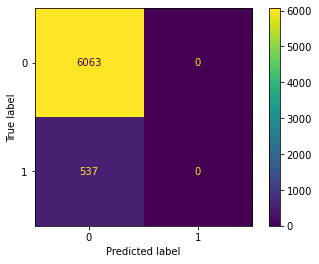

In [22]:
run_predictions(df, "logistic", scale=True)

Running preprocessing...
Pipeline: scaler -> classifier

--- Cross Validation ---
   fit_time  score_time  test_score
0  0.074499      0.0010      0.9190
1  0.071000      0.0010      0.9035
2  0.072001      0.0010      0.9115
3  0.069999      0.0010      0.9150
4  0.072500      0.0005      0.9140
5  0.071500      0.0005      0.9125
6  0.068500      0.0010      0.9145
7  0.071501      0.0010      0.9095
8  0.074499      0.0005      0.9075
9  0.071500      0.0005      0.9190
Average score:  0.9126000000000001

--- Train/Test Split ---
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      6063
           1       0.49      0.48      0.48       537

    accuracy                           0.92      6600
   macro avg       0.72      0.72      0.72      6600
weighted avg       0.92      0.92      0.92      6600



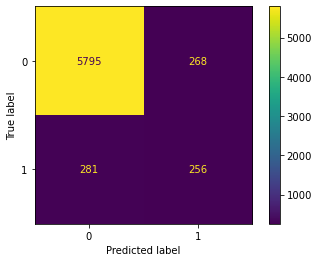

In [23]:
run_predictions(df, "tree", scale=True)

Running preprocessing...
Pipeline: scaler -> classifier

--- Cross Validation ---
   fit_time  score_time  test_score
0  2.206975    0.032499      0.9495
1  2.192500    0.032500      0.9405
2  2.180500    0.032501      0.9475
3  2.206499    0.033000      0.9435
4  2.210000    0.033502      0.9450
5  2.187000    0.032501      0.9445
6  2.203000    0.032000      0.9445
7  2.167999    0.032500      0.9420
8  2.218499    0.033500      0.9430
9  2.171499    0.033000      0.9460
Average score:  0.9446

--- Train/Test Split ---
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      6063
           1       0.87      0.39      0.54       537

    accuracy                           0.95      6600
   macro avg       0.91      0.69      0.75      6600
weighted avg       0.94      0.95      0.94      6600



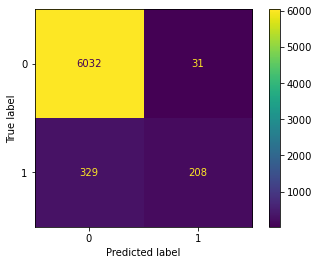

In [24]:
run_predictions(df, "forest", scale=True)

Running preprocessing...
Pipeline: scaler -> classifier

--- Cross Validation ---
E:\app-store\bin\miniconda3\envs\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
E:\app-store\bin\miniconda3\envs\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
E:\app-store\bin\miniconda3\envs\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
E:\app-store\bin\miniconda3\envs\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and th

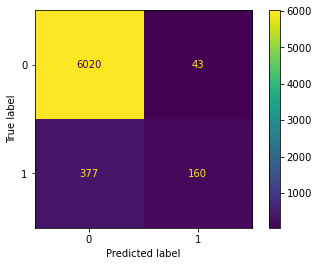

In [25]:
run_predictions(df, "mlp", scale=True)

Running preprocessing...
Pipeline: scaler -> classifier

--- Cross Validation ---
   fit_time  score_time  test_score
0  5.425501    0.677999      0.9190
1  5.555000    0.661497      0.9190
2  5.631501    0.665999      0.9190
3  5.927501    0.673500      0.9190
4  5.371001    0.655499      0.9185
5  5.410000    0.649501      0.9185
6  5.584004    0.662497      0.9185
7  5.782000    0.654500      0.9185
8  5.522999    0.645000      0.9185
9  5.258500    0.661500      0.9185
Average score:  0.9187

--- Train/Test Split ---
E:\app-store\bin\miniconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\app-store\bin\miniconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are il

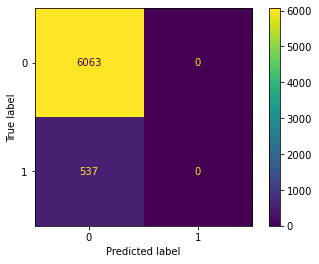

In [26]:
run_predictions(df, "svm", scale=True)

## Using Oversampling and Feature Scaling

Running preprocessing...
Pipeline: scaler -> classifier

--- Cross Validation ---
   fit_time  score_time  test_score
0  0.096999    0.097002    0.936054
1  0.089499    0.096501    0.941769
2  0.085000    0.093500    0.935510
3  0.083500    0.093501    0.941769
4  0.084500    0.093000    0.941769
5  0.078500    0.093500    0.940952
6  0.084500    0.093500    0.940136
7  0.087500    0.093500    0.943129
8  0.085000    0.092500    0.943930
9  0.085500    0.106002    0.946924
Average score:  0.941194308970186

--- Train/Test Split ---
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      6064
           1       0.87      0.99      0.93      6063

    accuracy                           0.93     12127
   macro avg       0.93      0.93      0.93     12127
weighted avg       0.93      0.93      0.93     12127



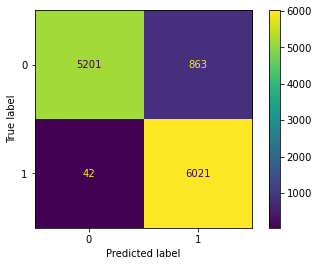

In [27]:
run_predictions(df, "knn", scale=True, oversample=True)

Running preprocessing...
Pipeline: scaler -> classifier

--- Cross Validation ---
   fit_time  score_time  test_score
0  0.010501    0.000500    0.644082
1  0.011500    0.000499    0.660136
2  0.009002    0.000997    0.663129
3  0.009001    0.000499    0.645986
4  0.009001    0.000500    0.647347
5  0.008502    0.000499    0.649524
6  0.009002    0.000499    0.646259
7  0.009500    0.000501    0.649252
8  0.010001    0.000499    0.661949
9  0.008999    0.000501    0.672020
Average score:  0.6539682712497084

--- Train/Test Split ---
              precision    recall  f1-score   support

           0       0.66      0.61      0.63      6064
           1       0.64      0.68      0.66      6063

    accuracy                           0.65     12127
   macro avg       0.65      0.65      0.65     12127
weighted avg       0.65      0.65      0.65     12127



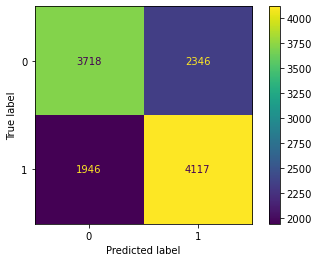

In [28]:
run_predictions(df, "logistic", scale=True, oversample=True)

Running preprocessing...
Pipeline: scaler -> classifier

--- Cross Validation ---
   fit_time  score_time  test_score
0  0.091499    0.001000    0.979320
1  0.088501    0.001499    0.977959
2  0.091000    0.001000    0.973333
3  0.091001    0.001001    0.977687
4  0.089999    0.001000    0.973333
5  0.090001    0.000999    0.980408
6  0.091500    0.001000    0.974422
7  0.089498    0.001000    0.976327
8  0.091000    0.001000    0.980131
9  0.091499    0.001000    0.978225
Average score:  0.9771145130888502

--- Train/Test Split ---
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      6064
           1       0.94      1.00      0.97      6063

    accuracy                           0.97     12127
   macro avg       0.97      0.97      0.97     12127
weighted avg       0.97      0.97      0.97     12127



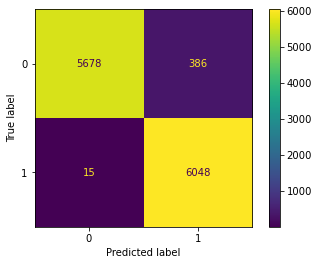

In [29]:
run_predictions(df, "tree", scale=True, oversample=True)

Running preprocessing...
Pipeline: scaler -> classifier

--- Cross Validation ---
   fit_time  score_time  test_score
0  3.209999    0.056000    0.989116
1  3.193000    0.054501    0.990204
2  3.208501    0.054998    0.986939
3  3.184500    0.055000    0.991020
4  3.183001    0.055499    0.992925
5  3.205000    0.055000    0.990204
6  3.202500    0.055500    0.988844
7  3.204501    0.057001    0.987755
8  3.222999    0.055000    0.991018
9  3.191500    0.054500    0.991835
Average score:  0.9899859279585541

--- Train/Test Split ---
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      6064
           1       0.97      1.00      0.98      6063

    accuracy                           0.98     12127
   macro avg       0.98      0.98      0.98     12127
weighted avg       0.98      0.98      0.98     12127



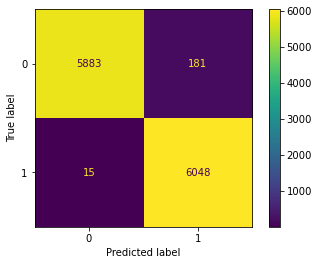

In [30]:
run_predictions(df, "forest", scale=True, oversample=True)

Running preprocessing...
Pipeline: scaler -> classifier

--- Cross Validation ---
E:\app-store\bin\miniconda3\envs\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
E:\app-store\bin\miniconda3\envs\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
E:\app-store\bin\miniconda3\envs\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
E:\app-store\bin\miniconda3\envs\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and th

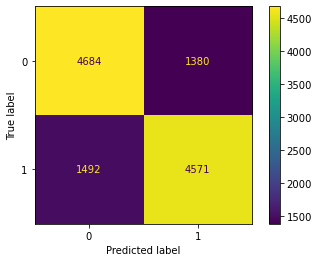

In [31]:
run_predictions(df, "mlp", scale=True, oversample=True)

Running preprocessing...
Pipeline: scaler -> classifier

--- Cross Validation ---
    fit_time  score_time  test_score
0  31.775999    5.902000    0.750476
1  32.076500    6.057000    0.753469
2  32.257499    6.064000    0.750748
3  32.042501    5.927999    0.752925
4  31.819000    5.881000    0.742857
5  32.462000    5.939500    0.749932
6  32.201501    5.948998    0.736327
7  32.786498    6.064145    0.746939
8  32.484534    6.014003    0.766195
9  33.029840    6.129500    0.754763
Average score:  0.750463155322009

--- Train/Test Split ---
              precision    recall  f1-score   support

           0       0.77      0.71      0.74      6064
           1       0.73      0.79      0.76      6063

    accuracy                           0.75     12127
   macro avg       0.75      0.75      0.75     12127
weighted avg       0.75      0.75      0.75     12127



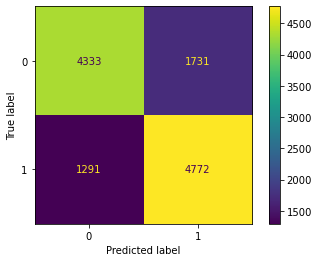

In [32]:
run_predictions(df, "svm", scale=True, oversample=True)

## Use the model to perform predictions

In [33]:
# --- start of model parameters ---

# dataset used to train the model
df_train = pd.read_csv('dataset/train_data.csv')

# dataset used to test the model
df_test = pd.read_csv('dataset/test_data_unlabeled.csv')

# --- end of model parameters ---

# split features and label, use all data in the training set (not splitting it as we do in above code)
X_train_real = df_train.iloc[:, 1:-1].values
y_train_real = df_train.iloc[:, -1].values

# do oversampling to handle imbalanced class
sampler = RandomOverSampler()
X_resampled, y_resampled = sampler.fit_resample(X_train_real, y_train_real)
#X_resampled, y_resampled = X_train_real, y_train_real

# select the same column from test dataset as the train dataset
X_new = df_test[TEST_COLUMNS].values

# fit the model
clf = MLPClassifier(random_state=42) #RandomForestClassifier()
clf.fit(X_resampled, y_resampled)

# run predictions, the result will be saved in y_pred as numpy array
y_pred = clf.predict(X_new)

E:\app-store\bin\miniconda3\envs\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [34]:
np.unique(y_pred, return_counts=True)

(array([0, 1], dtype=int64), array([7555, 2445], dtype=int64))

In [35]:
df_test["failed"] = y_pred
df_test[["job_id", "failed"]].to_csv('result.csv', index=None)

In [36]:
df_test["failed"].value_counts() / len(df_test) * 100

0    75.55
1    24.45
Name: failed, dtype: float64